# Pokemon Clustering Project

The aim of this project is to explore the k-means clustering algorithm and how it can be used to identify groups of similar objects within a dataset. To test this, I will use the pokedexg13.csv dataset, which features 432 rows and 13 columns. Each row represents a pokemon and each column represents a feature about that particular pokemon. 

I'll begin by importing the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Let's now import our data into pandas, and take a look at the first few rows. 

In [2]:
df=pd.read_csv("data/pokedexg13.csv")
print(df.shape)
df.head(3)

(432, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


We can see above that we have a mix of numerical and categorical features for each pokemon. Let's now define a distance measure to compare two pokemon. For this, I will use the L-2 norm or Euclidean Distance of the form

\begin{align}
    Dist(A, B) = \sum_{i=0} \sqrt{(A_i - B_i)^2} 
\end{align}

In [3]:
def distance(x1, x2):
    distance = np.sqrt(np.sum((x1 - x2)**2))
    return distance

Now that we have a proper distance measure, we can define our kmeans function which will perform the clustering.

In [4]:
def kmeans(df, k=4, tol=0.05): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    

    filtered_df = df[['HP', 'Attack', 'Defense']]
    centroids = df.sample(k)
    meanerror = np.inf
    prev_centroids = pd.DataFrame()
    
    
    while True:
        clusters = []
        
        for row_idx, row in filtered_df.iterrows():
            dists = []
            for c_idx, centroid in centroids.iterrows():
                dists.append(distance(row, centroid))
            closest_cent = np.argmin(dists)
            clusters.append(closest_cent)
            
            
        centroid_list = []
        
        for i in range(k):
            cluster = filtered_df[np.array(clusters) == i]
            if cluster.empty:
                centroid_list.append(centroids.iloc[i])
            else:
                centroid_list.append(cluster.mean())
            
        new_centroids = pd.DataFrame(centroid_list, columns=filtered_df.columns)
        
        if not prev_centroids.empty:
            err = []
            for i in range(k):
                err.append(distance(new_centroids.iloc[i], prev_centroids.iloc[i]))
            
            distance_to_centroid = []
            
            for idx, row in filtered_df.iterrows():
                cluster = clusters[idx]
                centroid = new_centroids.iloc[cluster]
                distance_to_centroid.append(distance(row, centroid))
            
            change_error = np.mean(err)
            mean_reconstruction_error = np.mean(distance_to_centroid)
            
            if change_error <= tol:
                break
            
            
            
        centroids = new_centroids.copy()
        prev_centroids = new_centroids.copy()

    return centroids, clusters, mean_reconstruction_error

Let's plot a graph showing the clustering taking place!

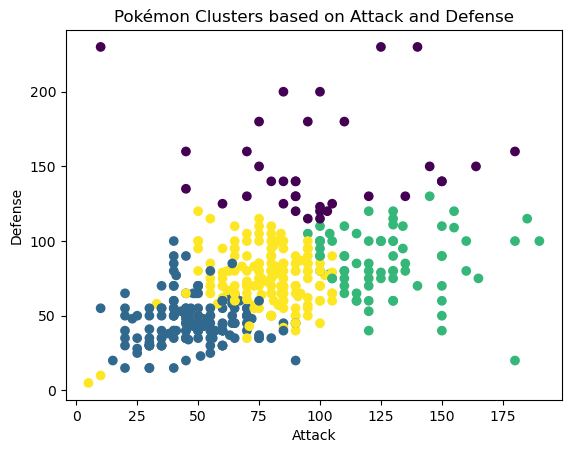

In [5]:
plt.scatter(df['Attack'], df['Defense'], c=kmeans(df)[1], cmap='viridis')
plt.xlabel('Attack')
plt.ylabel('Defense')
plt.title('Pokémon Clusters based on Attack and Defense')
plt.show()

We can clearly observe the effectiveness of the clustering above. There is an element of randomness to this algorithm, so each run of the function will not produce the same cluster assignments. Thus, let's run the algorithm multiple times for a particular value of $k$ and select the cluster assignments that minimized the total mean error. 

In [6]:
def multiple_kmean_run(iterations, k, kmeans = kmeans):
    multiK = pd.DataFrame()
    mean_errors = []

    for i in range(iterations):
        ret = kmeans(df, k, 0.05)
        multiK[f'{i}'] = ret[1]
        mean_errors.append(ret[2])
    return multiK, mean_errors


multiK, mean_errors = multiple_kmean_run(20, 4)

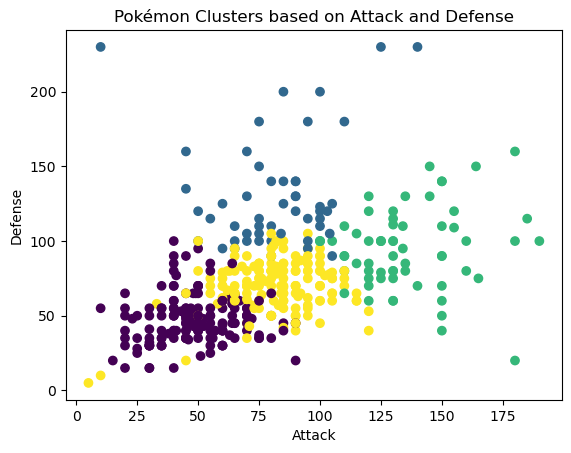

In [7]:
best_fit = np.argmin(mean_errors)
p1 = df.copy()
p1['Cluster'] = multiK[f'{best_fit}']

plt.scatter(p1['Attack'], p1['Defense'], c=p1['Cluster'], cmap='viridis')
plt.xlabel('Attack')
plt.ylabel('Defense')
plt.title('Pokémon Clusters based on Attack and Defense')
plt.show()

Furthermore, there was no reason to assume that 4 was the right choice for our $k$-value. Let's now execute the algorithm 10 times, for values of $k$ from 1-11. As $k$ increases, the total mean error will always decrease. However, it is likely that past a certain point, the rate of decrease will be minimal, leading us to select a smaller value of $k$ to save on computation time. We can visualize this with an elbow plot!

In [8]:
k_to_low = {}
for i in range(1, 11):
    multiK, mean_error = multiple_kmean_run(10, i)
    k_to_low[i] = np.min(mean_error)

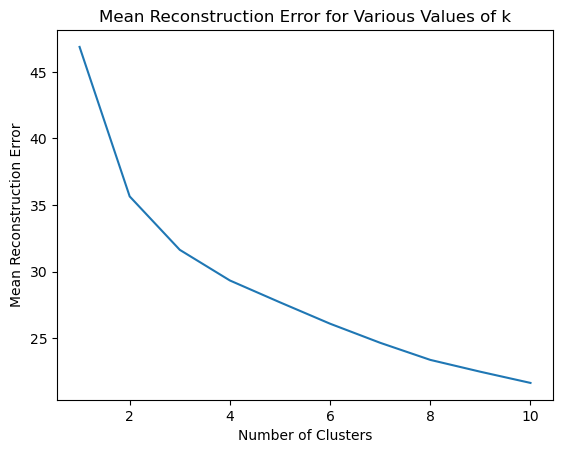

In [9]:
plt.plot(k_to_low.keys(), k_to_low.values())
plt.title("Mean Reconstruction Error for Various Values of k")
plt.xlabel("Number of Clusters")
plt.ylabel("Mean Reconstruction Error")
plt.show();

We can see that after k=4, the mean reconstruction error starts to descend slowly. For the rest of the project we will continue using $k=4$ as the optimal cluster number. 

### Part 2

One error with our process above is that we used the euclidean distance, which only accepts numerical values. I hypothesize that the type feature of a pokemon definitely has some relevance to our clustering, so we should find a way to implement it. For this, we will use a combination of the euclidean distance and the jaccard distance for our distance measure. The jaccard distance is simply the 1 minus the ratio between the intersection of two sets and the union, which makes it apt at comparing categorical variable. 

In [10]:
def euc_distance(pokemon1, pokemon2):
    #Do the thing
    pokemon1 = pokemon1[['HP', 'Attack', 'Defense']]
    pokemon2 = pokemon2[['HP', 'Attack', 'Defense']]
    dist = np.sqrt(np.sum((pokemon1 - pokemon2)**2))
    return dist
def jacc_distance(pokemon1, pokemon2):
    #Do the thing
    pokemon1 = pokemon1[['Type 1', 'Type 2']]
    pokemon2 = pokemon2[['Type 1', 'Type 2']]
    pokemon1 = pokemon1.dropna()
    pokemon2 = pokemon2.dropna()
    intersection = np.intersect1d(pokemon1, pokemon2)
    union = np.union1d(pokemon1, pokemon2)
    sim = len(intersection) / len(union)
    dist = 1 - sim
    return dist

In [13]:
def combined_dist(pokemon1, pokemon2, a): #a is the "percentage" that we'll weight Jaccard
    dist=100*(1-a)*euc_distance(pokemon1, pokemon2)+100*a*jacc_distance(pokemon1, pokemon2)
    return dist

In [14]:
def kmeans_modified(df, k=4, tol=0.05): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    

    numerical_df = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
    categorical_df = df[['Type 1', 'Type 2']]
    centroids = numerical_df.sample(k)
    meanerror = np.inf
    prev_centroids = pd.DataFrame()
    
    
    while True:
        clusters = []
        num_clusters = len(set(clusters))
        for row_idx, row in numerical_df.iterrows():
            dists = []
            for c_idx, centroid in centroids.iterrows():
                d = combined_dist(df.iloc[row_idx], df.iloc[c_idx], 0.995)
                dists.append(d)
            closest_cent = np.argmin(dists)
            clusters.append(closest_cent)
            
            
        centroid_list = []
        
        for i in range(k):
            cluster = numerical_df[np.array(clusters) == i]
            if cluster.empty:
                centroid_list.append(centroids.iloc[i])
            else:
                centroid_list.append(cluster.mean())
            
        new_centroids = pd.DataFrame(centroid_list, columns=numerical_df.columns)
        
        if not prev_centroids.empty:
            err = []
            for i in range(k):
                err.append(distance(new_centroids.iloc[i], prev_centroids.iloc[i]))
                
            reconstruction_error = np.mean(err)
            
            distance_to_centroid = []
            for idx, row in numerical_df.iterrows():
                cluster = clusters[idx]
                centroid = new_centroids.iloc[cluster]
                euc = euc_distance(row, centroid)
                
                
                
                jacc = jacc_distance(df.iloc[idx], categorical_df.iloc[clusters[idx]])
                d = euc + jacc
                distance_to_centroid.append(d)
                
            mean_reconstruction_error = np.mean(distance_to_centroid)
            
            if reconstruction_error <= tol:
                break
            
        centroids = new_centroids.copy()
        prev_centroids = new_centroids.copy()

    return centroids, clusters, mean_reconstruction_error


multiK, mean_errors = multiple_kmean_run(10, 4, kmeans_modified)

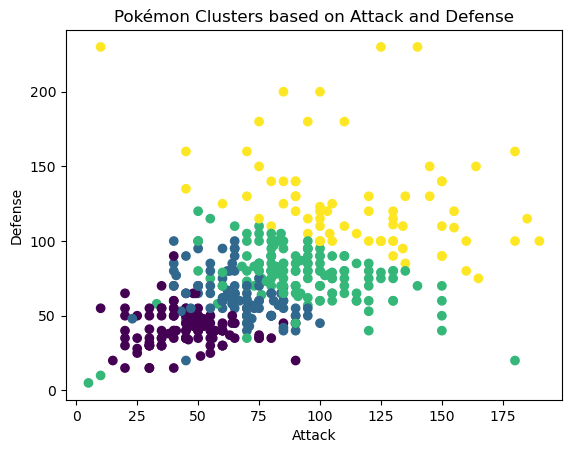

In [15]:
best_fit = np.argmin(mean_errors)

p2 = df.copy()
p2['Cluster'] = multiK[f'{best_fit}']

plt.scatter(p2['Attack'], p2['Defense'], c=p2['Cluster'], cmap='viridis')
plt.xlabel('Attack')
plt.ylabel('Defense')
plt.title('Pokémon Clusters based on Attack and Defense')
plt.show()